In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import time
import os
from dataclasses import dataclass
from collections import namedtuple
import pyro
import optax
from pyro.infer import SVI, TraceGraph_ELBO
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.contrib.examples.multi_mnist as multi_mnist
import torch
import torch.nn as nn
from torch.nn.functional import relu, sigmoid, softplus, grid_sample, affine_grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as font_manager
from matplotlib.patches import Rectangle
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import rcParams
from scipy.interpolate import griddata
import genjax
from genjax import grasp

key = jax.random.PRNGKey(314159)
console = genjax.pretty()
sns.set_theme(style="white")
# font_path = (
#     "/home/femtomc/.local/share/fonts/Unknown Vendor/TrueType/Lato/Lato_Bold.ttf"
# )
# font_manager.fontManager.addfont(font_path)
# custom_font_name = font_manager.FontProperties(fname=font_path).get_name()
# rcParams["font.family"] = custom_font_name

console = genjax.pretty()
key = jax.random.PRNGKey(314159)
label_fontsize = 70  # Set the desired font size here

smoke_test = "CI" in os.environ
assert pyro.__version__.startswith("1.8.6")

In [2]:
%load_ext line_profiler

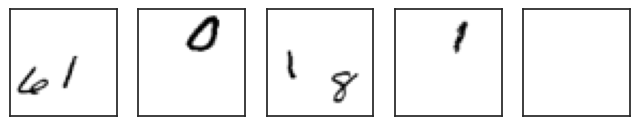

In [3]:
inpath = "./data/air/.data"
X_np, Y = multi_mnist.load(inpath)
X_np = X_np.astype(np.float32)
X_np /= 255.0
mnist = jnp.array(X_np)
true_counts = jnp.array([len(objs) for objs in Y])


def show_images(imgs):
    fig = plt.figure(figsize=(8, 2))
    for i, img in enumerate(imgs):
        ax = plt.subplot(1, len(imgs), i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(img, cmap="gray_r")


show_images(mnist[9:14])

## Defining the variational ingredients

### Utilities / learnable pieces

In [4]:
from genjax import Pytree
import equinox as eqx
from genjax.typing import Any
from genjax.typing import Tuple
from genjax.typing import FloatArray
from genjax.typing import Int
from genjax.typing import IntArray
from genjax.typing import PRNGKey
from genjax.typing import typecheck

# Utilities for defining the model and the guide.


@dataclass
class Decoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(50, 200, key=key1)
        dense_2 = eqx.nn.Linear(200, 400, key=key2)
        return Decoder(dense_1, dense_2)

    def __call__(self, z_what):
        v = self.dense_1(z_what)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return jax.nn.sigmoid(v)


# Create our decoder.
key, sub_key1, sub_key2 = jax.random.split(key, 3)
decoder = Decoder.new(sub_key1, sub_key2)

# Create our RNN for the guide.
key, sub_key = jax.random.split(key)
rnn = eqx.nn.LSTMCell(2554, 256, key=sub_key)


@dataclass
class Encoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(400, 200, key=key1)
        dense_2 = eqx.nn.Linear(200, 100, key=key2)
        return Encoder(dense_1, dense_2)

    def __call__(self, data):
        v = self.dense_1(data)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return v[0:50], jax.nn.softplus(v[50:])


key, sub_key1, sub_key2 = jax.random.split(key, 3)
encoder = Encoder.new(sub_key1, sub_key2)


@dataclass
class Predict(Pytree):
    dense: Any

    def flatten(self):
        return (self.dense,), ()

    @classmethod
    def new(cls, key):
        dense = eqx.nn.Linear(256, 7, key=key)
        return Predict(dense)

    def __call__(self, h):
        a = self.dense(h)
        z_pres_p = jax.nn.sigmoid(a[0:1])
        z_where_loc = a[1:4]
        z_where_scale = jax.nn.softplus(a[4:])
        return z_pres_p, z_where_loc, z_where_scale


key, sub_key = jax.random.split(key)
predict = Predict.new(key)

In [5]:
#######
# STN #
#######

# modified from https://github.com/kevinzakka/spatial-transformer-network/blob/master/stn/transformer.py


def affine_grid_generator(height, width, theta):
    """
    This function returns a sampling grid, which when
    used with the bilinear sampler on the input feature
    map, will create an output feature map that is an
    affine transformation [1] of the input feature map.

    Input
    -----
    - height: desired height of grid/output. Used
      to downsample or upsample.

    - width: desired width of grid/output. Used
      to downsample or upsample.

    - theta: affine transform matrices of shape (num_batch, 2, 3).
      For each image in the batch, we have 6 theta parameters of
      the form (2x3) that define the affine transformation T.

    Returns
    -------
    - normalized grid (-1, 1) of shape (num_batch, 2, H, W).
      The 2nd dimension has 2 components: (x, y) which are the
      sampling points of the original image for each point in the
      target image.

    Note
    ----
    [1]: the affine transformation allows cropping, translation,
         and isotropic scaling.
    """
    num_batch = theta.shape[0]

    # create normalized 2D grid
    x = jnp.linspace(-1.0, 1.0, width)
    y = jnp.linspace(-1.0, 1.0, height)
    x_t, y_t = jnp.meshgrid(x, y)

    # flatten
    x_t_flat = jnp.reshape(x_t, [-1])
    y_t_flat = jnp.reshape(y_t, [-1])

    # reshape to [x_t, y_t , 1] - (homogeneous form)
    ones = jnp.ones_like(x_t_flat)
    sampling_grid = jnp.stack([x_t_flat, y_t_flat, ones])

    # repeat grid num_batch times
    sampling_grid = jnp.expand_dims(sampling_grid, axis=0)
    sampling_grid = jnp.tile(sampling_grid, [num_batch, 1, 1])

    # transform the sampling grid - batch multiply
    batch_grids = jnp.matmul(theta, sampling_grid)
    # batch grid has shape (num_batch, 2, H*W)

    # reshape to (num_batch, 2, H, W)
    batch_grids = jnp.reshape(batch_grids, [num_batch, 2, height, width])

    return batch_grids


def bilinear_sampler(img, x, y):
    """
    Performs bilinear sampling of the input images according to the
    normalized coordinates provided by the sampling grid. Note that
    the sampling is done identically for each channel of the input.

    To test if the function works properly, output image should be
    identical to input image when theta is initialized to identity
    transform.

    Input
    -----
    - img: batch of images in (B, H, W, C) layout.
    - grid: x, y which is the output of affine_grid_generator.

    Returns
    -------
    - out: interpolated images according to grids. Same size as grid.
    """
    H = jnp.shape(img)[1]
    W = jnp.shape(img)[2]
    max_y = H - 1
    max_x = W - 1
    zero = jnp.zeros([], dtype=int)

    # rescale x and y to [0, W-1/H-1]
    x = 0.5 * ((x + 1.0) * max_x - 1)
    y = 0.5 * ((y + 1.0) * max_y - 1)

    # grab 4 nearest corner points for each (x_i, y_i)
    x0 = jnp.floor(x).astype(int)
    x1 = x0 + 1
    y0 = jnp.floor(y).astype(int)
    y1 = y0 + 1

    # clip to range [0, H-1/W-1] to not violate img boundaries
    x0 = jnp.clip(x0, zero, max_x)
    x1 = jnp.clip(x1, zero, max_x)
    y0 = jnp.clip(y0, zero, max_y)
    y1 = jnp.clip(y1, zero, max_y)

    # get pixel value at corner coords
    Ia = get_pixel_value(img, x0, y0)
    Ib = get_pixel_value(img, x0, y1)
    Ic = get_pixel_value(img, x1, y0)
    Id = get_pixel_value(img, x1, y1)

    # recast as float for delta calculation
    x0 = x0.astype(float)
    x1 = x1.astype(float)
    y0 = y0.astype(float)
    y1 = y1.astype(float)

    # calculate deltas
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    # add dimension for addition
    wa = jnp.expand_dims(wa, axis=3)
    wb = jnp.expand_dims(wb, axis=3)
    wc = jnp.expand_dims(wc, axis=3)
    wd = jnp.expand_dims(wd, axis=3)

    # compute output
    out = wa * Ia + wb * Ib + wc * Ic + wd * Id
    return out


def get_pixel_value(img, x, y):
    """
    Utility function to get pixel value for coordinate
    vectors x and y from a  4D tensor image.

    Input
    -----
    - img: tensor of shape (B, H, W, C)
    - x: flattened tensor of shape (B*H*W,)
    - y: flattened tensor of shape (B*H*W,)

    Returns
    -------
    - output: tensor of shape (B, H, W, C)
    """
    batch_size, height, width = jnp.shape(x)

    batch_idx = jnp.arange(0, batch_size)
    batch_idx = jnp.reshape(batch_idx, (batch_size, 1, 1))
    b = jnp.tile(batch_idx, (1, height, width))

    indices = jnp.stack([b, y, x], 3)

    return gather_nd(img, indices)


# from: https://github.com/google/jax/discussions/6119
def gather_nd_unbatched(params, indices):
    return params[tuple(jnp.moveaxis(indices, -1, 0))]


def gather_nd(params, indices, batch=False):
    if not batch:
        return gather_nd_unbatched(params, indices)
    else:
        return vmap(gather_nd_unbatched, (0, 0), 0)(params, indices)


def expand_z_where(z_where):
    # Takes 3-dimensional vectors, and massages them into 2x3 matrices with elements like so:
    # [s,x,y] -> [[s,0,x],
    #             [0,s,y]]
    n = 1
    expansion_indices = jnp.array([1, 0, 2, 0, 1, 3])
    z_where = jnp.expand_dims(z_where, axis=0)
    out = jnp.concatenate((jnp.broadcast_to(jnp.zeros([1, 1]), (n, 1)), z_where), 1)
    return jnp.reshape(out[:, expansion_indices], (n, 2, 3))


def object_to_image(z_where, obj):
    n = 1
    theta = expand_z_where(z_where)
    grid = affine_grid_generator(50, 50, theta)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    out = bilinear_sampler(jnp.reshape(obj, (n, 20, 20, 1)), x_s, y_s)
    return jnp.reshape(out, (50, 50))


def z_where_inv(z_where):
    # Take a batch of z_where vectors, and compute their "inverse".
    # That is, for each row compute:
    # [s,x,y] -> [1/s,-x/s,-y/s]
    # These are the parameters required to perform the inverse of the
    # spatial transform performed in the generative model.
    n = 1
    out = jnp.array([1, *(-z_where[1:])])
    out = out / z_where[0]
    return out


def image_to_object(z_where, image):
    n = 1
    theta_inv = expand_z_where(z_where_inv(z_where))
    grid = affine_grid_generator(20, 20, theta_inv)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    out = bilinear_sampler(jnp.reshape(image, (n, 50, 50, 1)), x_s, y_s)
    return jnp.reshape(out, (400,))

### Model

In [6]:
#########
# Model #
#########

# Fixed constants.
z_where_prior_loc = jnp.array([3.0, 0.0, 0.0])
z_where_prior_scale = jnp.array([0.1, 1.0, 1.0])
z_what_prior_loc = jnp.zeros(50, dtype=float)
z_what_prior_scale = jnp.ones(50, dtype=float)


@genjax.gen
@typecheck
def step(
    t: Int,
    decoder: Decoder,
    prev_x: FloatArray,
    prev_z_pres: IntArray,
):
    z_pres = grasp.flip_enum(0.5 * prev_z_pres[0]) @ f"z_pres_{t}"
    z_pres = jnp.array([z_pres.astype(int)])
    z_where = (
        grasp.mv_normal_diag_reparam(z_where_prior_loc, z_where_prior_scale)
        @ f"z_where_{t}"
    )
    z_what = (
        grasp.mv_normal_diag_reparam(z_what_prior_loc, z_what_prior_scale)
        @ f"z_what_{t}"
    )
    y_att = decoder(z_what)
    y = object_to_image(z_where, y_att)
    x = prev_x + (y * z_pres)
    return x, z_pres


# TODO: Make sure that this works, where t is a static int.
@genjax.gen
@typecheck
def model(decoder: Decoder):
    x = jnp.zeros((50, 50), dtype=float)
    z_pres = jnp.ones(1, dtype=int)
    for t in range(3):
        x, z_pres = step.inline(t, decoder, x, z_pres)
    obs = grasp.mv_normal_diag_reparam(x, 0.3 * jnp.ones_like(x)) @ "obs"
    return x

#### Samples from the model

In [7]:
tr = jax.jit(model.simulate)(key, (decoder,))
tr.strip()




├── :z_pres_0
│   └──  bool[]
├── :z_pres_1
│   └──  bool[]
├── :z_where_1
│   └──  f32[3]
├── :obs
│   └──  f32[50,50]
├── :z_what_1
│   └──  f32[50]
├── :z_what_2
│   └──  f32[50]
├── :z_pres_2
│   └──  bool[]
├── :z_what_0
│   └──  f32[50]
├── :z_where_2
│   └──  f32[3]
└── :z_where_0
    └──  f32[3]

### Guide

In [8]:
#########
# Guide #
#########


@genjax.gen
@typecheck
def guide_step(
    t: Int,
    rnn: eqx.nn.LSTMCell,
    encoder: Encoder,
    predict: Predict,
    data,
    prev: Tuple,
):
    (prev_z_where, prev_z_what, prev_z_pres, prev_h, prev_c) = prev
    rnn_input = jnp.concatenate([data, prev_z_where, prev_z_what, prev_z_pres])
    h, c = rnn(rnn_input, (prev_h, prev_c))
    z_pres_p, z_where_loc, z_where_scale = predict(h)
    z_pres = grasp.flip_enum(z_pres_p[0] * prev_z_pres[0]) @ f"z_pres_{t}"
    z_pres = jnp.array([z_pres.astype(int)])
    z_where = grasp.mv_normal_diag_reparam(z_where_loc, z_where_scale) @ f"z_where_{t}"
    x_att = image_to_object(z_where, data)
    z_what_loc, z_what_scale = encoder(x_att)
    z_what = grasp.mv_normal_diag_reparam(z_what_loc, z_what_scale) @ f"z_what_{t}"
    return z_where, z_what, z_pres, h, c


@genjax.gen
@typecheck
def guide(
    data: genjax.ChoiceMap,
    rnn: eqx.nn.LSTMCell,
    encoder: Encoder,
    predict: Predict,
):
    h = jnp.zeros(256)
    c = jnp.zeros(256)
    z_pres = jnp.ones(1)
    z_where = jnp.zeros(3)
    z_what = jnp.zeros(50)
    img = data["obs"]
    img_arr = img.flatten()

    for t in range(3):
        (z_where, z_what, z_pres, h, c) = guide_step.inline(
            t, rnn, encoder, predict, img_arr, (z_where, z_what, z_pres, h, c)
        )

#### Samples from the guide

In [9]:
data_chm = genjax.choice_map({"obs": jnp.ones((50, 50))})
tr = jax.jit(guide.simulate)(key, (data_chm, rnn, encoder, predict))
tr.strip()




├── :z_pres_0
│   └──  bool[]
├── :z_pres_1
│   └──  bool[]
├── :z_where_1
│   └──  f32[3]
├── :z_what_1
│   └──  f32[50]
├── :z_what_2
│   └──  f32[50]
├── :z_pres_2
│   └──  bool[]
├── :z_what_0
│   └──  f32[50]
├── :z_where_2
│   └──  f32[3]
└── :z_where_0
    └──  f32[3]

## Training

### Make sure grads are working

#### Define ELBO objective

In [10]:
data = genjax.choice_map({"obs": jnp.ones((50, 50))})
objective = grasp.elbo(model, guide, data)

#### Go go grads

In [11]:
jitted = jax.jit(objective.value_and_grad_estimate)
loss, ((decoder_grads,), (_, rnn_grads, encoder_grads, predict_grads)) = jitted(
    key, ((decoder,), (data, rnn, encoder, predict))
)

In [12]:
loss

Array(-9799.294, dtype=float32)

### Dataloader

In [13]:
def generators(
    data,
    split="train",
    shuffle=True,
):
    num_records = len(data[0])
    batch_size = num_records
    idxs = np.arange(num_records)

    def init():
        return (
            num_records // batch_size,
            np.random.permutation(idxs) if shuffle else idxs,
        )

    def get_batch(i=0, idxs=idxs):
        ret_idx = jax.lax.dynamic_slice_in_dim(idxs, i * batch_size, batch_size)
        return tuple(
            np.take(a, ret_idx, axis=0)
            if isinstance(a, list)
            else jax.lax.index_take(a, (ret_idx,), axes=(0,))
            for a in data
        )

    return init, get_batch


def circular_data_loader(data, batch_size):
    M, N, H = data.shape
    num_complete_batches, leftover = divmod(M, batch_size)

    # Start with the complete batches
    batches = [
        data[i * batch_size : (i + 1) * batch_size] for i in range(num_complete_batches)
    ]

    # Handle the last batch if there's a leftover
    if leftover:
        last_batch = jnp.concatenate(
            [data[-leftover:], data[: batch_size - leftover]], axis=0
        )
        batches.append(last_batch)

    return generators(batches)

In [14]:
##################
# Count Accuracy #
##################
def count_accuracy(data, true_counts, guide, batch_size=1000):
    global prng_key
    assert data.shape[0] == true_counts.shape[0], "Size mismatch."
    assert data.shape[0] % batch_size == 0, "Input size must be multiple of batch_size."

    def eval_guide(key, data, params):
        data_chmp = genjax.choice_map({"obs": data})
        return guide.simulate(key, (data_chmp, *params))

    batch_eval_guide = jax.jit(jax.vmap(eval_guide, in_axes=(0, 0, None)))

    @jax.jit
    def evaluate_count_accuracy(key, params):
        def evaluate_batch(counts, batch_id):
            data_batch = jax.lax.dynamic_slice_in_dim(
                data, batch_id * batch_size, batch_size
            )
            true_counts_batch = jax.lax.dynamic_slice_in_dim(
                true_counts, batch_id * batch_size, batch_size
            )
            data_chmp = genjax.choice_map({"obs": data_batch})
            # evaluate guide
            keys = jax.random.split(jax.random.fold_in(key, batch_id), batch_size)
            tr = batch_eval_guide(keys, data_batch, params)
            z_where = [tr[f"z_where_{i}"] for i in range(3)]
            z_pres = [tr[f"z_pres_{i}"] for i in range(3)]
            # compute stats
            inferred_counts = sum(z for z in z_pres)
            true_counts_m = jax.nn.one_hot(true_counts_batch, 3)
            inferred_counts_m = jax.nn.one_hot(inferred_counts, 4)
            counts += (true_counts_m.T @ inferred_counts_m).astype(int)
            error_ind = 1 - (true_counts_batch == inferred_counts).astype(int)
            # error_ix = error_ind.nonzero()[0]
            # error_latent = jnp.take(latents_to_tensor((z_where, z_pres)), error_ix, 0)
            return counts, error_ind

        counts = jnp.zeros((3, 4), dtype=int)
        counts, error_indices = jax.lax.scan(
            evaluate_batch, counts, jnp.arange(data.shape[0] // batch_size)
        )

        acc = jnp.sum(jnp.diag(counts)).astype(float) / data.shape[0]
        error_indices = jnp.concatenate(
            error_indices
        )  # .nonzero()[0]  # <- not JIT compilable
        return acc, counts, error_indices

    return evaluate_count_accuracy


# Combine z_pres and z_where (as returned by the model and guide) into
# a single tensor, with size:
# [batch_size, num_steps, z_where_size + z_pres_size]
def latents_to_tensor(z):
    return jnp.stack(
        [
            jnp.concatenate((z_where, z_pres.reshape(-1, 1)), 1)
            for z_where, z_pres in zip(*z)
        ]
    ).transpose(1, 0, 2)

In [15]:
##################
# Visualization  #
##################
def bounding_box(z_where, x_size):
    """This doesn't take into account interpolation, but it's close
    enough to be usable."""
    w = x_size / z_where.s
    h = x_size / z_where.s
    xtrans = -z_where.x / z_where.s * x_size / 2.0
    ytrans = -z_where.y / z_where.s * x_size / 2.0
    x = (x_size - w) / 2 + xtrans  # origin is top left
    y = (x_size - h) / 2 + ytrans
    return (x, y), w, h


z_obj = namedtuple("z", ["s", "x", "y", "pres"])


# Map a tensor of latents (as produced by latents_to_tensor) to a list
# of z_obj named tuples.
def tensor_to_objs(latents):
    return [[z_obj._make(step) for step in z] for z in latents]


def visualize_model(model, guide):
    def reconstruct_digits(key, data, params):
        decoder, rnn, encoder, predict = params
        data_chmp = genjax.choice_map({"obs": data})
        key1, key2 = jax.random.split(key)
        tr = guide.simulate(key1, (data_chmp, rnn, encoder, predict))
        _, tr = model.importance(key2, tr, (decoder,))
        reconstruction = tr.get_retval()
        z_where = [tr[f"z_where_{i}"] for i in range(3)]
        z_pres = [tr[f"z_pres_{i}"] for i in range(3)]
        return reconstruction, (z_where, z_pres)

    batch_reconstruct_digits = jax.jit(
        jax.vmap(reconstruct_digits, in_axes=(0, 0, None))
    )

    def visualize(key, params, examples_to_viz):
        keys = jax.random.split(key, examples_to_viz.shape[0])
        recons, z = batch_reconstruct_digits(keys, examples_to_viz, params)
        z_wheres = tensor_to_objs(latents_to_tensor(z))
        draw_many(examples_to_viz.reshape(-1, 50, 50), z_wheres, title="Original")
        draw_many(recons, z_wheres, title="Reconstruction")

    return visualize


def colors(k):
    return ["r", "g", "b"][k % 3]


def draw_one(img, z):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap="gray_r")
    for k, z in enumerate(z):
        if z.pres > 0:
            (x, y), w, h = bounding_box(z, img.shape[0])
            plt.gca().add_patch(
                Rectangle(
                    (x, y), w, h, linewidth=1, edgecolor=colors(k), facecolor="none"
                )
            )


def draw_many(imgs, zs, title):
    plt.figure(figsize=(8, 1.9))
    plt.title(title)
    plt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    plt.box(False)
    for i, (img, z) in enumerate(zip(imgs, zs)):
        plt.subplot(1, len(imgs), i + 1)
        draw_one(img, z)
    plt.show()

In [16]:
params = (decoder, rnn, encoder, predict)
evaluate_accuracy = count_accuracy(mnist, true_counts, guide, batch_size=1000)

visualize_examples = mnist[5:10]
visualize = visualize_model(model, guide)

Epoch=0, elapsed=16.57, loss=-3986.20
accuracy=0.29546666145324707, counts=[[10227  4907  2426  2388]
 [10254  5016  2362  2388]
 [10126  5057  2485  2364]]


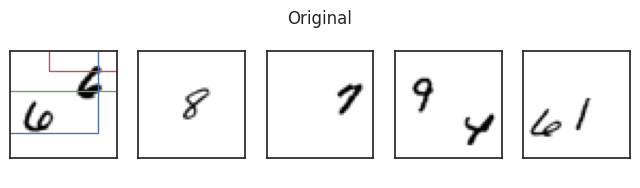

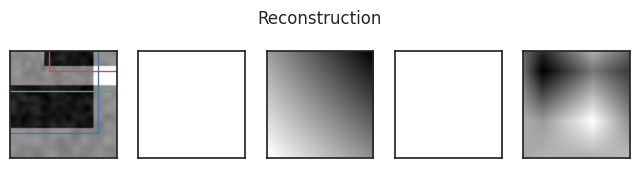

Epoch=100, elapsed=25.54, loss=-1251.42
accuracy=0.2520333230495453, counts=[[10302  5356  2475  1815]
 [14560  4698   677    85]
 [17194  2711   122     5]]
Epoch=200, elapsed=26.10, loss=-325.27
accuracy=0.23813334107398987, counts=[[10601  6010  2437   900]
 [16085  3671   259     5]
 [18583  1433    16     0]]
Epoch=300, elapsed=26.68, loss=99.11
accuracy=0.23115000128746033, counts=[[10801  7084  1905   158]
 [16875  3062    82     1]
 [19075   951     6     0]]
Epoch=400, elapsed=27.27, loss=247.73
accuracy=0.22936667501926422, counts=[[10874  7743  1294    37]
 [17062  2883    75     0]
 [19218   809     5     0]]
Epoch=500, elapsed=27.86, loss=288.90
accuracy=0.22993333637714386, counts=[[10870  8108   944    26]
 [17054  2921    45     0]
 [19256   771     5     0]]
Epoch=600, elapsed=28.46, loss=299.43
accuracy=0.23096667230129242, counts=[[11088  8025   815    20]
 [17199  2763    58     0]
 [19242   783     7     0]]
Epoch=700, elapsed=29.06, loss=322.88
accuracy=0.22908332

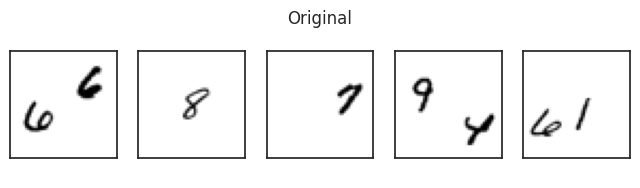

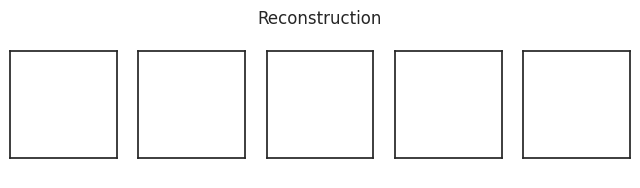

Epoch=1100, elapsed=31.63, loss=330.45
accuracy=0.23194999992847443, counts=[[11199  7902   830    17]
 [17247  2713    60     0]
 [19262   765     5     0]]
Epoch=1200, elapsed=32.23, loss=359.35
accuracy=0.2305999994277954, counts=[[11239  7799   893    17]
 [17360  2591    68     1]
 [19240   786     6     0]]
Epoch=1300, elapsed=32.82, loss=340.08
accuracy=0.23221667110919952, counts=[[11314  7699   916    19]
 [17355  2610    54     1]
 [19301   722     9     0]]
Epoch=1400, elapsed=33.42, loss=369.70
accuracy=0.23356667160987854, counts=[[11348  7754   833    13]
 [17288  2653    79     0]
 [19288   731    13     0]]
Epoch=1500, elapsed=34.02, loss=370.95
accuracy=0.2315666675567627, counts=[[11221  7797   914    16]
 [17292  2662    66     0]
 [19270   751    11     0]]
Epoch=1600, elapsed=34.62, loss=379.44
accuracy=0.23465000092983246, counts=[[11378  7691   849    30]
 [17263  2697    60     0]
 [19213   815     4     0]]
Epoch=1700, elapsed=35.22, loss=382.21
accuracy=0.2337

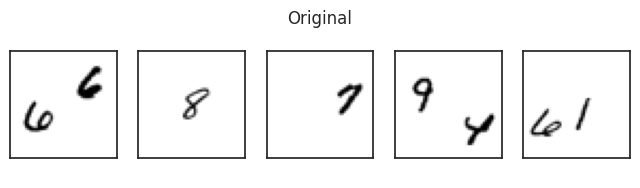

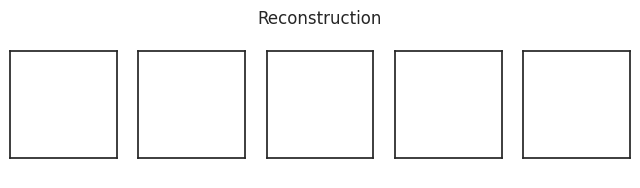

Epoch=2100, elapsed=37.81, loss=427.38
accuracy=0.2389666736125946, counts=[[11654  7338   919    37]
 [17273  2677    69     1]
 [19214   811     7     0]]
Epoch=2200, elapsed=38.41, loss=431.44
accuracy=0.2409999966621399, counts=[[11799  7293   829    27]
 [17299  2652    68     1]
 [19179   844     9     0]]
Epoch=2300, elapsed=39.02, loss=445.35
accuracy=0.242249995470047, counts=[[11867  7238   818    25]
 [17280  2660    78     2]
 [19193   831     8     0]]
Epoch=2400, elapsed=39.62, loss=449.74
accuracy=0.2418166697025299, counts=[[11885  7216   818    29]
 [17308  2616    96     0]
 [19153   871     8     0]]
Epoch=2500, elapsed=40.23, loss=457.84
accuracy=0.2443000078201294, counts=[[12030  7066   830    22]
 [17320  2618    80     2]
 [19208   814    10     0]]
Epoch=2600, elapsed=40.84, loss=458.92
accuracy=0.24498333036899567, counts=[[12161  6963   809    15]
 [17410  2532    78     0]
 [19212   814     6     0]]
Epoch=2700, elapsed=41.45, loss=464.44
accuracy=0.24608333

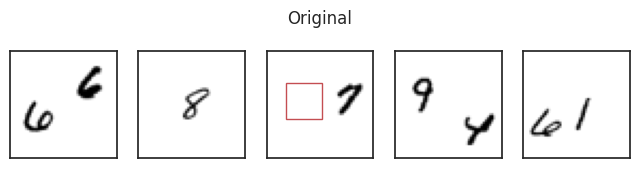

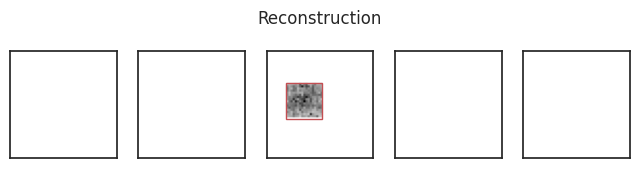

Epoch=3100, elapsed=44.07, loss=473.92
accuracy=0.2500166594982147, counts=[[12443  6801   679    25]
 [17391  2547    79     3]
 [19160   861    11     0]]
Epoch=3200, elapsed=44.69, loss=477.58
accuracy=0.250733345746994, counts=[[12566  6696   669    17]
 [17490  2472    57     1]
 [19193   833     6     0]]
Epoch=3300, elapsed=45.30, loss=476.53
accuracy=0.25013333559036255, counts=[[12590  6630   712    16]
 [17545  2404    70     1]
 [19103   915    14     0]]
Epoch=3400, elapsed=45.91, loss=477.40
accuracy=0.2533000111579895, counts=[[12727  6487   703    31]
 [17471  2463    84     2]
 [19145   879     8     0]]
Epoch=3500, elapsed=46.52, loss=477.71
accuracy=0.25029999017715454, counts=[[12626  6642   663    17]
 [17580  2387    52     1]
 [19177   850     5     0]]
Epoch=3600, elapsed=47.13, loss=478.16
accuracy=0.2543666660785675, counts=[[12877  6481   572    18]
 [17582  2377    61     0]
 [19195   828     8     1]]
Epoch=3700, elapsed=47.75, loss=478.18
accuracy=0.2559500

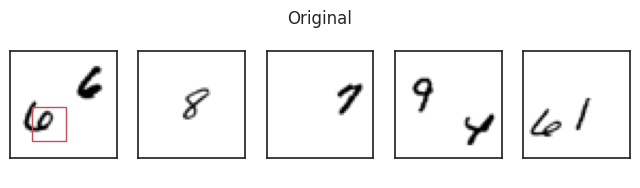

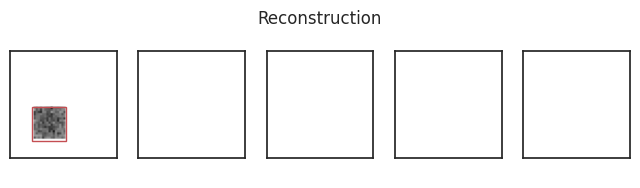

Epoch=4100, elapsed=50.38, loss=478.73
accuracy=0.255950003862381, counts=[[13047  6344   544    13]
 [17669  2307    44     0]
 [19264   765     3     0]]
Epoch=4200, elapsed=50.99, loss=479.39
accuracy=0.2564333379268646, counts=[[13076  6344   518    10]
 [17652  2304    64     0]
 [19223   803     6     0]]
Epoch=4300, elapsed=51.60, loss=478.71
accuracy=0.2589000165462494, counts=[[13259  6171   510     8]
 [17701  2270    48     1]
 [19267   760     5     0]]
Epoch=4400, elapsed=52.21, loss=479.64
accuracy=0.2583500146865845, counts=[[13263  6184   486    15]
 [17730  2230    60     0]
 [19218   806     8     0]]
Epoch=4500, elapsed=52.83, loss=478.54
accuracy=0.25876668095588684, counts=[[13263  6204   469    12]
 [17711  2254    55     0]
 [19209   814     9     0]]
Epoch=4600, elapsed=53.44, loss=480.44
accuracy=0.25920000672340393, counts=[[13332  6108   495    13]
 [17752  2215    52     1]
 [19244   783     5     0]]
Epoch=4700, elapsed=54.05, loss=479.94
accuracy=0.2634166

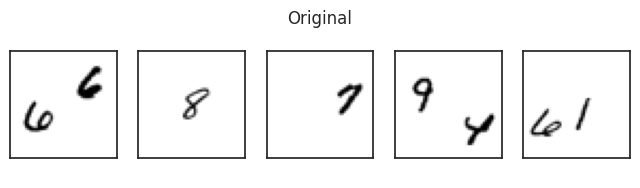

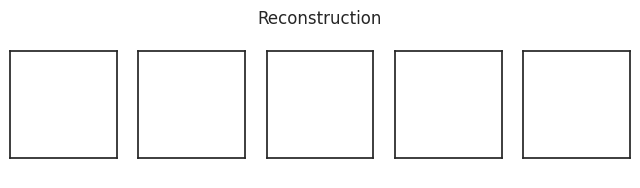

Epoch=5100, elapsed=56.67, loss=480.38
accuracy=0.2668166756629944, counts=[[13603  5916   418    11]
 [17576  2394    49     1]
 [19140   879    12     1]]
Epoch=5200, elapsed=57.28, loss=481.25
accuracy=0.26793333888053894, counts=[[13739  5780   417    12]
 [17643  2328    49     0]
 [19051   972     9     0]]
Epoch=5300, elapsed=57.89, loss=480.15
accuracy=0.27121666073799133, counts=[[13796  5696   447     9]
 [17493  2470    57     0]
 [19021  1004     7     0]]
Epoch=5400, elapsed=58.50, loss=480.74
accuracy=0.2733500003814697, counts=[[13941  5608   387    12]
 [17488  2452    79     1]
 [18929  1095     8     0]]
Epoch=5500, elapsed=59.12, loss=480.99
accuracy=0.27596667408943176, counts=[[13982  5517   436    13]
 [17383  2563    73     1]
 [18855  1164    13     0]]
Epoch=5600, elapsed=59.73, loss=480.48
accuracy=0.2785833477973938, counts=[[13946  5603   393     6]
 [17194  2750    76     0]
 [18685  1328    19     0]]
Epoch=5700, elapsed=60.34, loss=482.36
accuracy=0.28533

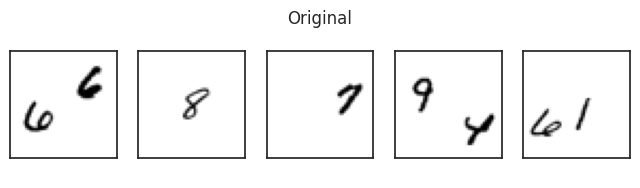

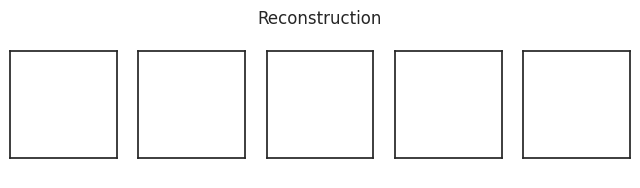

Epoch=6100, elapsed=62.97, loss=483.29
accuracy=0.3133000135421753, counts=[[14294  5186   456    12]
 [15358  4325   327    10]
 [16544  3301   179     8]]
Epoch=6200, elapsed=63.58, loss=484.73
accuracy=0.33623334765434265, counts=[[14279  5123   527    19]
 [14072  5201   684    63]
 [14351  4864   694   123]]
Epoch=6300, elapsed=64.19, loss=490.02
accuracy=0.37025001645088196, counts=[[14145  5137   643    23]
 [11030  5865  1824  1301]
 [ 9569  5556  2205  2702]]
Epoch=6400, elapsed=64.80, loss=501.10
accuracy=0.32670000195503235, counts=[[13968  5344   614    22]
 [ 7418  4211  1821  6570]
 [ 4281  2445  1423 11883]]
Epoch=6500, elapsed=65.42, loss=523.80
accuracy=0.27158334851264954, counts=[[13780  5290   835    43]
 [ 4275  2183  1008 12554]
 [ 1548   601   332 17551]]
Epoch=6600, elapsed=66.03, loss=545.10
accuracy=0.2444000095129013, counts=[[13603  5323   971    51]
 [ 2371  1009   424 16216]
 [  542   118    52 19320]]
Epoch=6700, elapsed=66.64, loss=552.93
accuracy=0.2325

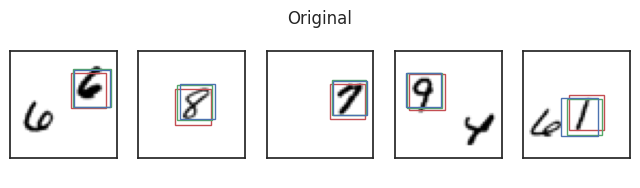

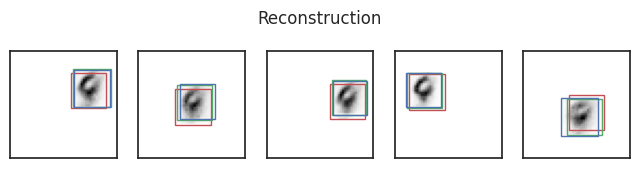

Epoch=7100, elapsed=69.32, loss=564.37
accuracy=0.233883336186409, counts=[[13748  5489   694    17]
 [  801   281   130 18808]
 [   62     9     4 19957]]
Epoch=7200, elapsed=69.94, loss=566.33
accuracy=0.23576666414737701, counts=[[13897  5451   583    17]
 [  689   244   122 18965]
 [   43     8     5 19976]]
Epoch=7300, elapsed=70.56, loss=567.63
accuracy=0.23808333277702332, counts=[[14030  5447   462     9]
 [  663   250    99 19008]
 [   47     4     5 19976]]
Epoch=7400, elapsed=71.18, loss=568.38
accuracy=0.24311667680740356, counts=[[14326  5243   374     5]
 [  655   258   112 18995]
 [   39     5     3 19985]]
Epoch=7500, elapsed=71.79, loss=570.42
accuracy=0.24823333323001862, counts=[[14625  5001   321     1]
 [  594   267   118 19041]
 [   37     2     2 19991]]
Epoch=7600, elapsed=72.40, loss=572.62
accuracy=0.25306665897369385, counts=[[14919  4786   242     1]
 [  590   262   110 19058]
 [   21     2     3 20006]]
Epoch=7700, elapsed=73.01, loss=575.12
accuracy=0.2581

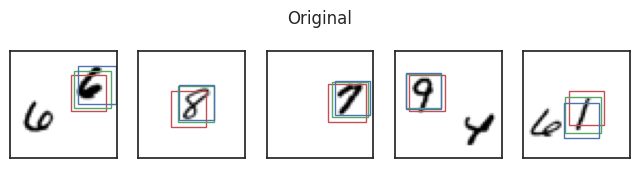

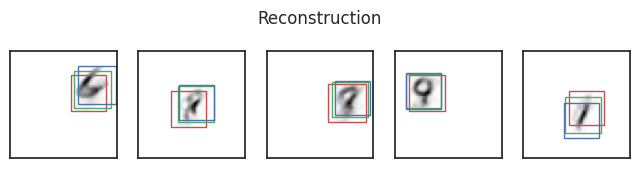

Epoch=8100, elapsed=76.01, loss=582.70
accuracy=0.2777666747570038, counts=[[16383  3489    76     0]
 [  605   279   116 19020]
 [   16     3     4 20009]]
Epoch=8200, elapsed=76.62, loss=584.07
accuracy=0.2825666666030884, counts=[[16675  3206    67     0]
 [  614   279    98 19029]
 [   20     2     0 20010]]
Epoch=8300, elapsed=77.24, loss=583.82
accuracy=0.2869666814804077, counts=[[16916  2974    58     0]
 [  615   301   107 18997]
 [   19     0     1 20012]]
Epoch=8400, elapsed=77.85, loss=582.80
accuracy=0.2891499996185303, counts=[[17047  2854    46     1]
 [  640   301   106 18973]
 [   16     1     1 20014]]
Epoch=8500, elapsed=78.46, loss=586.94
accuracy=0.2934499979019165, counts=[[17305  2599    44     0]
 [  617   301   135 18967]
 [   12     2     1 20017]]
Epoch=8600, elapsed=79.07, loss=587.22
accuracy=0.2948499917984009, counts=[[17409  2511    28     0]
 [  615   279   129 18997]
 [   14     2     3 20013]]
Epoch=8700, elapsed=79.68, loss=588.99
accuracy=0.30110001

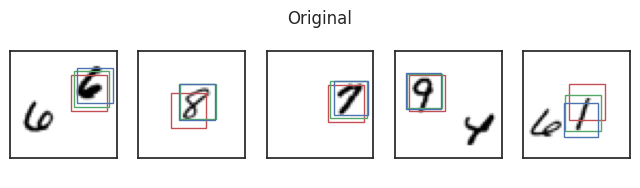

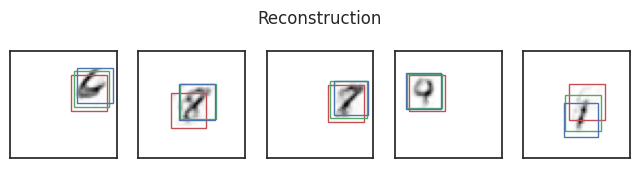

Epoch=9100, elapsed=82.35, loss=591.85
accuracy=0.3100166618824005, counts=[[18313  1620    15     0]
 [  656   286    99 18979]
 [   12     0     2 20018]]
Epoch=9200, elapsed=82.96, loss=592.98
accuracy=0.31158334016799927, counts=[[18432  1508     8     0]
 [  659   261   107 18993]
 [    5     2     2 20023]]
Epoch=9300, elapsed=83.57, loss=594.10
accuracy=0.3141666650772095, counts=[[18574  1367     7     0]
 [  667   274    84 18995]
 [   11     2     2 20017]]
Epoch=9400, elapsed=84.19, loss=594.56
accuracy=0.3151833415031433, counts=[[18647  1290    11     0]
 [  615   262   110 19033]
 [    6     2     2 20022]]
Epoch=9500, elapsed=84.80, loss=595.63
accuracy=0.3172333240509033, counts=[[18759  1182     7     0]
 [  647   273    86 19014]
 [    5     1     2 20024]]
Epoch=9600, elapsed=85.41, loss=593.89
accuracy=0.3186500072479248, counts=[[18845  1103     0     0]
 [  680   271    84 18985]
 [    5     1     3 20023]]
Epoch=9700, elapsed=86.02, loss=597.03
accuracy=0.3189833

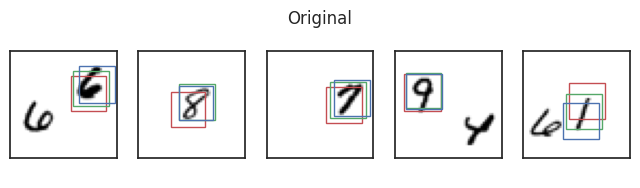

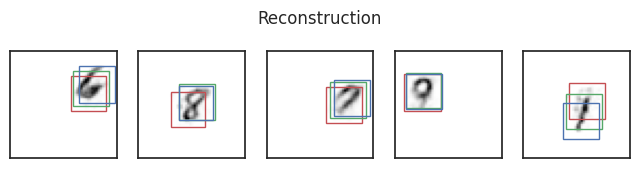

Epoch=10100, elapsed=88.70, loss=597.25
accuracy=0.32420000433921814, counts=[[19191   756     1     0]
 [  694   259    84 18983]
 [    7     5     2 20018]]
Epoch=10200, elapsed=89.31, loss=598.82
accuracy=0.3252499997615814, counts=[[19243   702     3     0]
 [  691   272    94 18963]
 [    5     0     0 20027]]
Epoch=10300, elapsed=89.92, loss=599.46
accuracy=0.32553333044052124, counts=[[19293   650     5     0]
 [  720   238   104 18958]
 [    6     2     1 20023]]
Epoch=10400, elapsed=90.53, loss=600.05
accuracy=0.32706665992736816, counts=[[19358   588     2     0]
 [  740   265    70 18945]
 [    5     1     1 20025]]
Epoch=10500, elapsed=91.14, loss=600.05
accuracy=0.3270333409309387, counts=[[19372   576     0     0]
 [  701   249    82 18988]
 [    8     0     1 20023]]
Epoch=10600, elapsed=91.76, loss=599.43
accuracy=0.32750001549720764, counts=[[19386   561     1     0]
 [  726   264    77 18953]
 [    6     0     0 20026]]
Epoch=10700, elapsed=92.37, loss=599.29
accuracy

In [ ]:
batch_size = 64
learning_rate = 1.0e-4
num_epochs = 200000


def svi_update(model, guide, optimiser):
    def batch_updater(key, params, opt_state, data_batch):
        def grads(key, params, data):
            (decoder, rnn, encoder, predict) = params
            data = genjax.choice_map({"obs": data})
            objective = grasp.elbo(model, guide, data)
            loss, (
                (decoder_grads,),
                (_, rnn_grads, encoder_grads, predict_grads),
            ) = objective.value_and_grad_estimate(
                key, ((decoder,), (data, rnn, encoder, predict))
            )
            return loss, (decoder_grads, rnn_grads, encoder_grads, predict_grads)

        sub_keys = jax.random.split(key, len(data_batch))
        loss, (decoder_grads, rnn_grads, encoder_grads, predict_grads) = jax.vmap(
            grads, in_axes=(0, None, 0)
        )(sub_keys, params, data_batch)

        grads = jtu.tree_map(
            lambda v: -1.0 * jnp.mean(v, axis=0),
            (decoder_grads, rnn_grads, encoder_grads, predict_grads),
        )
        updates, opt_state = optimiser.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        loss = jnp.mean(loss)
        return params, opt_state, loss

    return batch_updater


adam = optax.adam(learning_rate)
svi_updater = svi_update(model, guide, adam)
train_init, train_fetch = circular_data_loader(mnist, batch_size)
num_train, train_idx = train_init()


@jax.jit
def epoch_train(opt_state, params, key, train_idx):
    def body_fn(carry, xs):
        idx, params, opt_state, loss = carry
        updater_key = jax.random.fold_in(key, idx)
        batch = train_fetch(idx, train_idx)[0]
        params, opt_state, loss = svi_updater(updater_key, params, opt_state, batch)
        idx += 1
        return (idx, params, opt_state, loss), loss

    idx = 0
    (_, params, opt_state, _), losses = jax.lax.scan(
        body_fn, (idx, params, opt_state, 0.0), None, length=num_train
    )
    return params, opt_state, losses


# Train.
key = jax.random.PRNGKey(314159)
params = (decoder, rnn, encoder, predict)
opt_state = adam.init(params)
t0 = time.perf_counter()
losses = []
accuracy = []
for i in range(0, num_epochs):
    key, sub_key = jax.random.split(key)
    num_train, train_idx = train_init()
    params, opt_state, loss = epoch_train(opt_state, params, sub_key, train_idx)
    losses.extend(loss)
    if i % 100 == 0:
        elapsed = time.perf_counter() - t0
        print(f"Epoch={i}, elapsed={elapsed:.2f}, loss={jnp.mean(loss):.2f}")
        acc, counts, error_ix = evaluate_accuracy(sub_key, params[1:])
        accuracy.append(acc)
        print("accuracy={}, counts={}".format(acc, counts))
    if i % 1000 == 0:
        visualize(sub_key, params, visualize_examples)

In [ ]:
(trained_decoder, _, _, _) = params
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 4)
tr = jax.jit(jax.vmap(model.simulate, in_axes=(0, None)))(sub_keys, (trained_decoder,))
generated = tr.get_retval()
show_images(generated)

In [ ]:
plt.plot(losses[:5000])